### Fake and Real News Detection using LSTM Deep Learning

#### Library Imports

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [158]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

### Exploring Fake News

In [159]:
fake=pd.read_csv('Fake.csv')

In [160]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [161]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [162]:
fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

C:\Users\Hp\AppData\Local\Temp\ipykernel_22324\3379759318.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='subject', data=fake, palette='Set1')


<Axes: xlabel='subject', ylabel='count'>

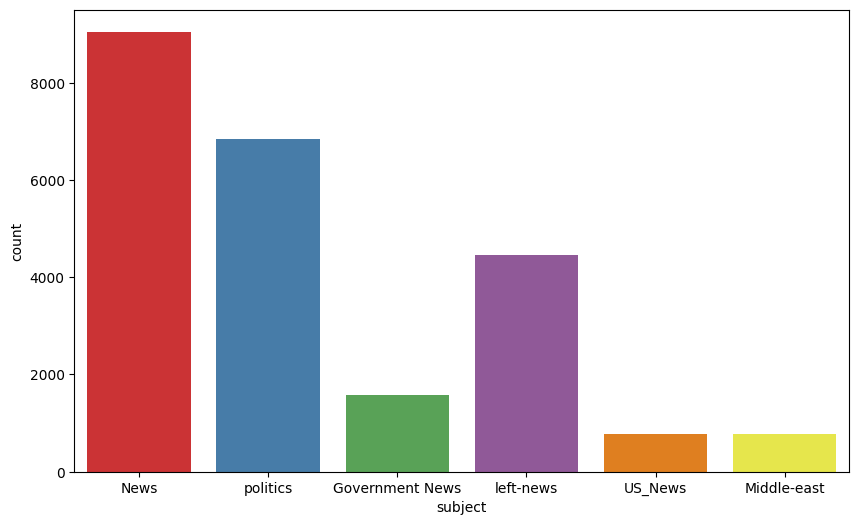

In [163]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject', data=fake, palette='Set1')

### WordCloud

In [164]:
text=' '.join(fake['text'].tolist())

In [165]:
' '.join(['this','is','a','data'])

'this is a data'

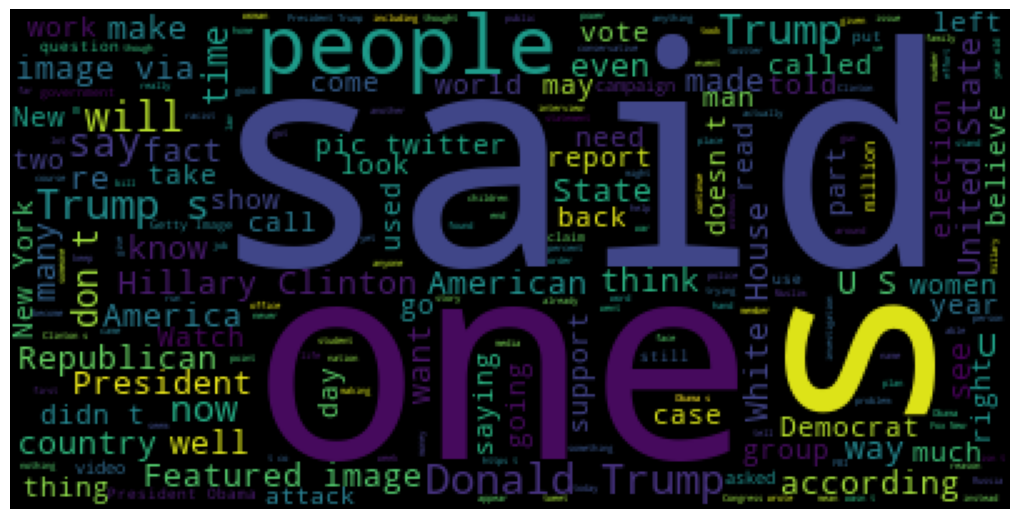

In [166]:
wordcloud=WordCloud().generate(text)
fig=plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Exploring Fake News

In [167]:
real=pd.read_csv('True.csv')

In [168]:
real_text=' '.join(real['text'].tolist())

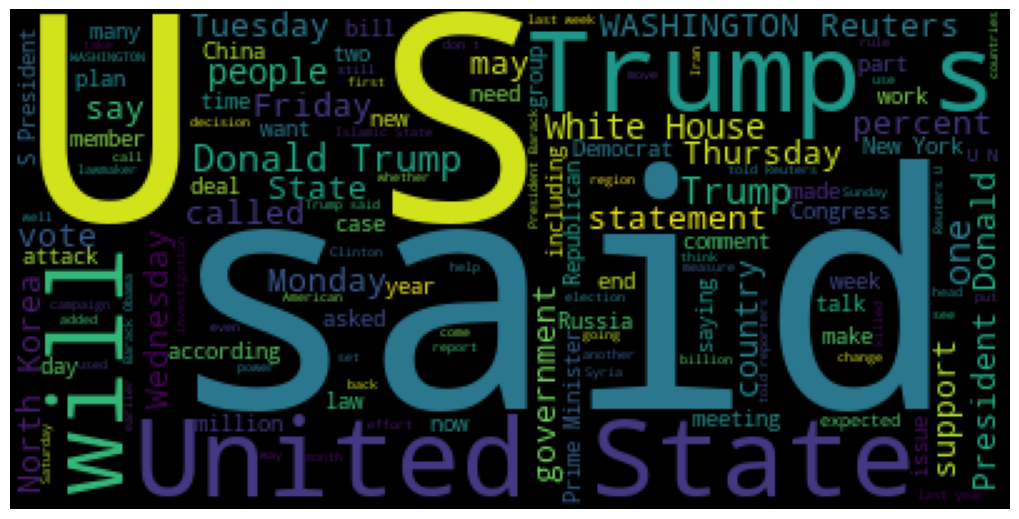

In [169]:
wordcloud=WordCloud().generate(real_text)
fig=plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Difference in Text

Real news seems to have source of publication which is not present in fake news set.

Looking at the dataset:
- Most of the text contains reuters informations
- Some text are tweets from twitter
- Few texts do not contain any publication info

### Clearning Data

Removing Reuters or Twitter Tweet information from the text:
- Text can be splitted only once at "-" which is always present after mentioning source of publication, this gives us publication part and text part
- If we do not get text part, this means publication detaisl wasn't given for that period
- The twitters tweets always have the same source, a long text of max 259 characters

In [170]:
real.sample(5)

,title,text,subject,date
11117,"Watch out frontrunners, over 1,500 candidates ...",CHICAGO (Reuters) - Michael Petyo is a carpent...,politicsNews,"January 25, 2016"
21372,U.N. calls for pause in air strikes to spare c...,GENEVA (Reuters) - The United Nations called o...,worldnews,"August 24, 2017"
12470,France's Le Drian says 'no' to Iran Mediterran...,PARIS (Reuters) - France s foreign minister cr...,worldnews,"December 12, 2017"
9106,Factbox: Eyes on U.S. terrorism watchlists aft...,"(Reuters) - As facts emerge about Omar Mateen,...",politicsNews,"June 15, 2016"
7346,"Bannon, Priebus top candidates for White House...",WASHINGTON (Reuters) - Donald Trump’s campaign...,politicsNews,"November 10, 2016"


In [171]:
real.text.values

array(['WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support

In [172]:
real.sample(5)

,title,text,subject,date
6605,Democrats lean on drug pricing as Obamacare re...,WASHINGTON/NEW YORK (Reuters) - Democrats are ...,politicsNews,"December 22, 2016"
4960,Trump to nominate CFTC acting head Giancarlo a...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"March 15, 2017"
14727,Memories in milk bottles: Polish exhibition 's...,WARSAW (Reuters) - A deeply moving exhibition ...,worldnews,"November 15, 2017"
10313,"After crucial win, Kasich sees path to Republi...","BEREA, Ohio (Reuters) - After a critical win o...",politicsNews,"March 16, 2016"
16083,Czech Babis gains possible support in bid for ...,PRAGUE (Reuters) - Czech billionaire Andrej Ba...,worldnews,"October 30, 2017"


In [173]:
unknown_publishers=[]
for index, row in enumerate(real.text.values):
    try:
        ## Finding data that is either from Reuters or tweets
        # Finding news from reuters
        record=row.split('-', maxsplit=1)
        record[1]
        # Tweet data
        assert(len(record[0])<120)
    except:
        unknown_publishers.append(index)

In [174]:
len(unknown_publishers)

222

In [175]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [176]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [177]:
# real=real.drop(8970, axis=0)

In [178]:
# Taking text data and publishers info in both known and unknown sources
publisher=[]
tmp_text=[]

for index, row in enumerate(real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append('Unknown')
    else:
        record=row.split('-', maxsplit=1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())

In [179]:
real['publisher']=publisher
real['text']=tmp_text

In [180]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [181]:
real.shape

(21417, 5)

In [182]:
empty_fake_index = [index for index, text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [183]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [184]:
real['text']=real['title']+" "+real['text']
fake['text']=fake['title']+" "+fake['text']

In [185]:
real['text']=real['text'].apply(lambda x:str(x).lower())
fake['text']=fake['text'].apply(lambda x:str(x).lower())

### Preprocessing Text

In [186]:
real['class']=1
fake['class']=0

In [187]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [188]:
real=real[['text', 'class']]

In [189]:
fake=fake[['text', 'class']]

In [191]:
data=real.concat(fake, ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'concat'

In [156]:
data.sample(5)

NameError: name 'data' is not defined